In [1]:
!pip install transformers
!pip install keras_tuner
!pip install tensorflow_text

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [3]:
import pandas as pd
import numpy as np
from transformers import AutoTokenizer, TFBertModel
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
from keras.models import Model, Sequential
from keras.layers import Input, Dense, Dropout, Embedding, LSTM, RNN, SimpleRNN, GRU
from tensorflow.keras import regularizers
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

In [4]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [5]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' not in s]
    val_loss_list = [s for s in history.history.keys() if 'loss' in s and 'val' in s]
    acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' not in s]
    val_acc_list = [s for s in history.history.keys() if 'acc' in s and 'val' in s]

    if len(loss_list) == 0:
        print('Loss is missing in history')
        return

    ## As loss always exists
    epochs = range(1,len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(epochs, history.history[l], 'b', label='Training loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))
    for l in val_loss_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation loss (' + str(str(format(history.history[l][-1],'.5f'))+')'))

    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    ## Accuracy
    plt.figure(2)
    for l in acc_list:
        plt.plot(epochs, history.history[l], 'b', label='Training accuracy (' + str(format(history.history[l][-1],'.5f'))+')')
    for l in val_acc_list:
        plt.plot(epochs, history.history[l], 'g', label='Validation accuracy (' + str(format(history.history[l][-1],'.5f'))+')')

    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

In [6]:
df = pd.read_csv("subtaskA_train.csv")

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1842 entries, 0 to 1841
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              1842 non-null   int64 
 1   comment_text    1842 non-null   object
 2   conspiratorial  1842 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 43.3+ KB


In [8]:
df = df[:800]

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              800 non-null    int64 
 1   comment_text    800 non-null    object
 2   conspiratorial  800 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 18.9+ KB


## Pre processing

<Axes: >

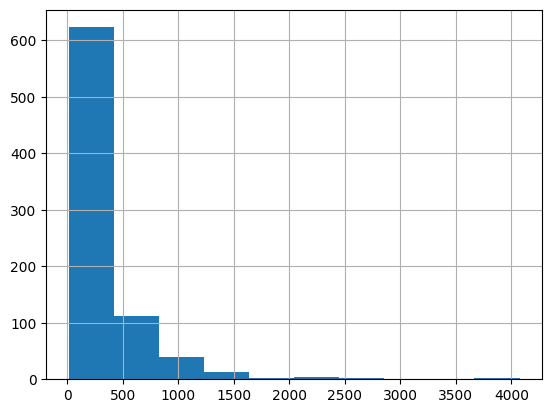

In [10]:
df["comment_text"].map(len).hist()

<Axes: >

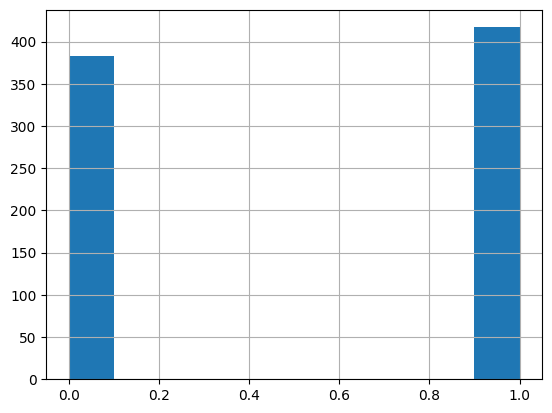

In [11]:
df["conspiratorial"].hist()

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Id              800 non-null    int64 
 1   comment_text    800 non-null    object
 2   conspiratorial  800 non-null    int64 
dtypes: int64(2), object(1)
memory usage: 18.9+ KB


## Costruzione di train e test set

In [13]:
X = df["comment_text"]
y = df["conspiratorial"]

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.25, random_state = 10)

In [15]:
#tfhub_handle_encoder = "https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_L-24_H-1024_A-16/1"
#tfhub_handle_preprocess = "https://tfhub.dev/jeongukjae/xlm_roberta_multi_cased_preprocess/1"
tfhub_handle_encoder = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"
tfhub_handle_preprocess = "https://tfhub.dev/google/universal-sentence-encoder-multilingual/3"

In [65]:
def build_classifier_model():
    # defining inputs
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')

    # defining preprocessing
    #preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')

    # defining encoder
    #encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=False, name='BERT_encoder')

    # defining outputs
    #outputs = encoder(encoder_inputs)
    net = encoder(text_input)
    #net = outputs['pooled_output']
    #net = tf.keras.layers.Dropout(0.1)(net)

    # Reshape net to add a time step dimension
    net = tf.expand_dims(net, axis=1)

    lstm_units = 3 # hp.Int('units', min_value=5, max_value=30, step=5)
    #model.add(keras.layers.Dense(units=hp_units, activation='relu'))

    net = LSTM(
        units=5,
        #kernel_regularizer=regularizers.L2(l2=1e-5),
        #dropout=0.1
    )(net)
    """
    net = tf.keras.layers.LSTM(
        units = lstm_units
    )(net)
    """
    net = tf.keras.layers.Dense(20,activation="relu")(net)
    net = tf.keras.layers.Dense(20, activation="relu")(net)
    net = tf.keras.layers.Dense(20, activation="relu")(net)
    net = tf.keras.layers.Dense(1, activation="sigmoid", name='classifier')(net)

    model = tf.keras.Model(text_input, net)

    """
    optimizer = Adam(
        learning_rate=hp.Choice('learning_rate', values=[1e-4, 1e-5, 1e-6]),
        epsilon=1e-08,
        clipnorm=0.1
    )
    """
    optimizer = Adam(
        learning_rate=1e-4,
        epsilon=1e-08,
        clipnorm=0.1
    )

    model.compile(
        optimizer=optimizer,
        loss = 'binary_crossentropy',
        metrics = 'accuracy'
    )

    return model


In [44]:
"""
tuner = kt.RandomSearch(
    hypermodel=build_classifier_model,
    objective='val_accuracy'
)
"""

"\ntuner = kt.RandomSearch(\n    hypermodel=build_classifier_model,\n    objective='val_accuracy'\n)\n"

In [45]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.Accuracy()

In [46]:
"""
print(f'Training model with {tfhub_handle_encoder}')
tuner.search(
    x = X_train,
    y = y_train,
    epochs = 5,
    validation_split = 0.25,
    callbacks = [
        #EarlyStopping(monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)
    ]
)
"""

"\nprint(f'Training model with {tfhub_handle_encoder}')\ntuner.search(\n    x = X_train, \n    y = y_train,\n    epochs = 5, \n    validation_split = 0.25, \n    callbacks = [\n        #EarlyStopping(monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)\n    ]\n)\n"

In [66]:
classifier_model = build_classifier_model()

In [67]:
%%time
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(
    x = X_train,
    y = y_train,
    epochs=200,
    validation_split = 0.25,
    batch_size = 32,
    callbacks= [
        # EarlyStopping( monitor='val_accuracy' ,mode='max', patience=3,verbose=False,restore_best_weights=True)
    ]
)


Training model with https://tfhub.dev/google/universal-sentence-encoder-multilingual/3
Epoch 1/200
15/15 [==============================] - 13s 150ms/step - loss: 0.6933 - accuracy: 0.4844 - val_loss: 0.6932 - val_accuracy: 0.5067
Epoch 2/200
15/15 [==============================] - 1s 66ms/step - loss: 0.6931 - accuracy: 0.5178 - val_loss: 0.6930 - val_accuracy: 0.4933
Epoch 3/200
15/15 [==============================] - 1s 66ms/step - loss: 0.6930 - accuracy: 0.5267 - val_loss: 0.6928 - val_accuracy: 0.5467
Epoch 4/200
15/15 [==============================] - 1s 55ms/step - loss: 0.6929 - accuracy: 0.5467 - val_loss: 0.6926 - val_accuracy: 0.5400
Epoch 5/200
15/15 [==============================] - 1s 67ms/step - loss: 0.6927 - accuracy: 0.5600 - val_loss: 0.6925 - val_accuracy: 0.5600
Epoch 6/200
15/15 [==============================] - 1s 38ms/step - loss: 0.6925 - accuracy: 0.5778 - val_loss: 0.6923 - val_accuracy: 0.5800
Epoch 7/200
15/15 [==============================] - 1s 37m

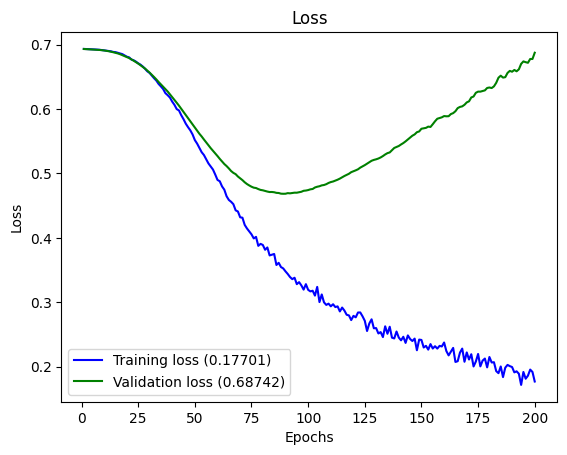

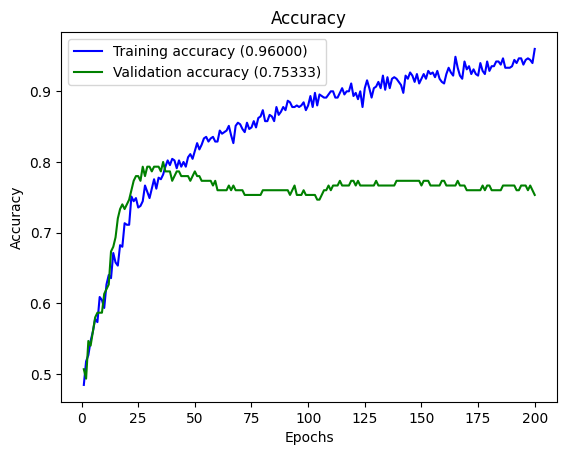

In [68]:
plot_history(history)